In [1]:
import scipy
import sklearn
import numpy as np
import pandas as pd
import datetime as dt
import seaborn as sns

import scipy.stats as st

from joblib import dump, load
import matplotlib.pyplot as plt

from sklearn.cluster import AgglomerativeClustering, KMeans
from sklearn.feature_selection import RFE, SelectKBest, f_classif, chi2

import statsmodels.api as sm
import statsmodels.formula.api as smf

from sklearn import preprocessing, decomposition
from sklearn.model_selection import train_test_split

from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.metrics import accuracy_score, confusion_matrix, silhouette_score, davies_bouldin_score, ConfusionMatrixDisplay, recall_score, precision_score

pd.set_option('display.max_columns', 80)
pd.set_option('display.max_rows', 40)

sns.set(style='whitegrid')

In [2]:
print(f'sklearn: {sklearn.__version__}')

sklearn: 1.3.0


In [3]:
df = pd.read_csv('./banknote.csv', encoding='utf_8', encoding_errors='strict')

In [4]:
display(df[:5])
display(df[-5:])
display(df.sample(5))

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
0,True,171.81,104.86,104.95,4.52,2.89,112.83
1,True,171.67,103.74,103.70,4.01,2.87,113.29
2,True,171.83,103.76,103.76,4.40,2.88,113.84
3,True,171.80,103.78,103.65,3.73,3.12,113.63
4,True,172.05,102.70,103.75,5.04,2.27,113.55


,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
165,False,172.11,104.23,104.45,5.24,3.58,111.78
166,False,174.01,104.59,104.31,5.04,3.05,110.91
167,False,172.47,104.27,104.10,4.88,3.33,110.68
168,False,171.82,102.97,103.88,4.73,3.55,111.87
169,False,171.96,104.00,103.95,5.63,3.26,110.96


,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
10,True,172.27,104.29,104.22,3.89,3.53,113.50
35,True,171.66,104.17,104.16,4.75,2.94,113.52
5,True,172.57,104.65,104.44,4.54,2.99,113.16
29,True,171.84,103.75,103.38,4.08,2.70,113.72
142,False,171.69,104.18,104.28,5.62,3.23,110.53


In [5]:
df['is_genuine'].value_counts()

is_genuine
True     100
False     70
Name: count, dtype: int64

### Nous connaissons pour chaque billet les étiquettes (vrai / faux).
### L'application d'un modèle d'apprentissage supervisé pourra permettre de prédire la qualité des billets (vrai / faux).

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 170 entries, 0 to 169
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   is_genuine    170 non-null    bool   
 1   diagonal      170 non-null    float64
 2   height_left   170 non-null    float64
 3   height_right  170 non-null    float64
 4   margin_low    170 non-null    float64
 5   margin_up     170 non-null    float64
 6   length        170 non-null    float64
dtypes: bool(1), float64(6)
memory usage: 8.3 KB


In [7]:
df['is_genuine'] = df['is_genuine'].astype('string')

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 170 entries, 0 to 169
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   is_genuine    170 non-null    string 
 1   diagonal      170 non-null    float64
 2   height_left   170 non-null    float64
 3   height_right  170 non-null    float64
 4   margin_low    170 non-null    float64
 5   margin_up     170 non-null    float64
 6   length        170 non-null    float64
dtypes: float64(6), string(1)
memory usage: 9.4 KB


In [9]:
# Valeurs manquantes
df.isna().sum().sort_values(ascending=False)

is_genuine      0
diagonal        0
height_left     0
height_right    0
margin_low      0
margin_up       0
length          0
dtype: int64

In [10]:
# duplicate data is most commonly rows of data that are exactly the same across all columns
df.duplicated().any()

False

In [11]:
df.describe(include='all').transpose()

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
is_genuine,170,2,True,100,NaN,NaN,NaN,NaN,NaN,NaN,NaN
diagonal,170.0,NaN,NaN,NaN,171.999412,0.430086,171.04,171.73,171.95,172.1475,174.01
height_left,170.0,NaN,NaN,NaN,103.978118,0.428798,102.47,103.76,104.03,104.28,104.86
height_right,170.0,NaN,NaN,NaN,103.928118,0.33098,103.14,103.69,103.95,104.17,104.95
margin_low,170.0,NaN,NaN,NaN,4.612118,0.702103,3.54,4.05,4.45,5.1275,6.28
margin_up,170.0,NaN,NaN,NaN,3.170412,0.236361,2.27,3.0125,3.17,3.33,3.68
length,170.0,NaN,NaN,NaN,112.570412,0.924448,109.97,111.855,112.845,113.2875,113.98


In [12]:
data = df['is_genuine'].value_counts()
data

is_genuine
True     100
False     70
Name: count, dtype: Int64

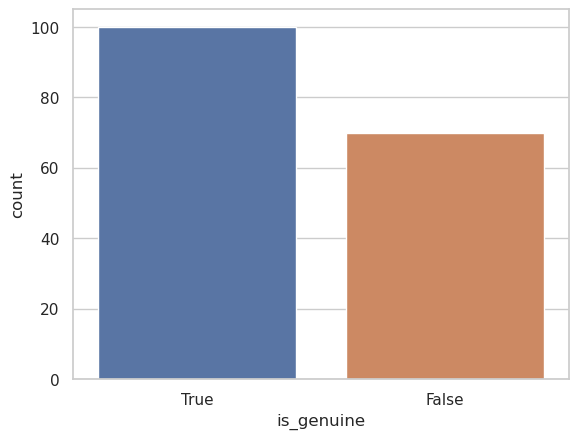

In [13]:
sns.countplot(x=df['is_genuine'])
plt.show()

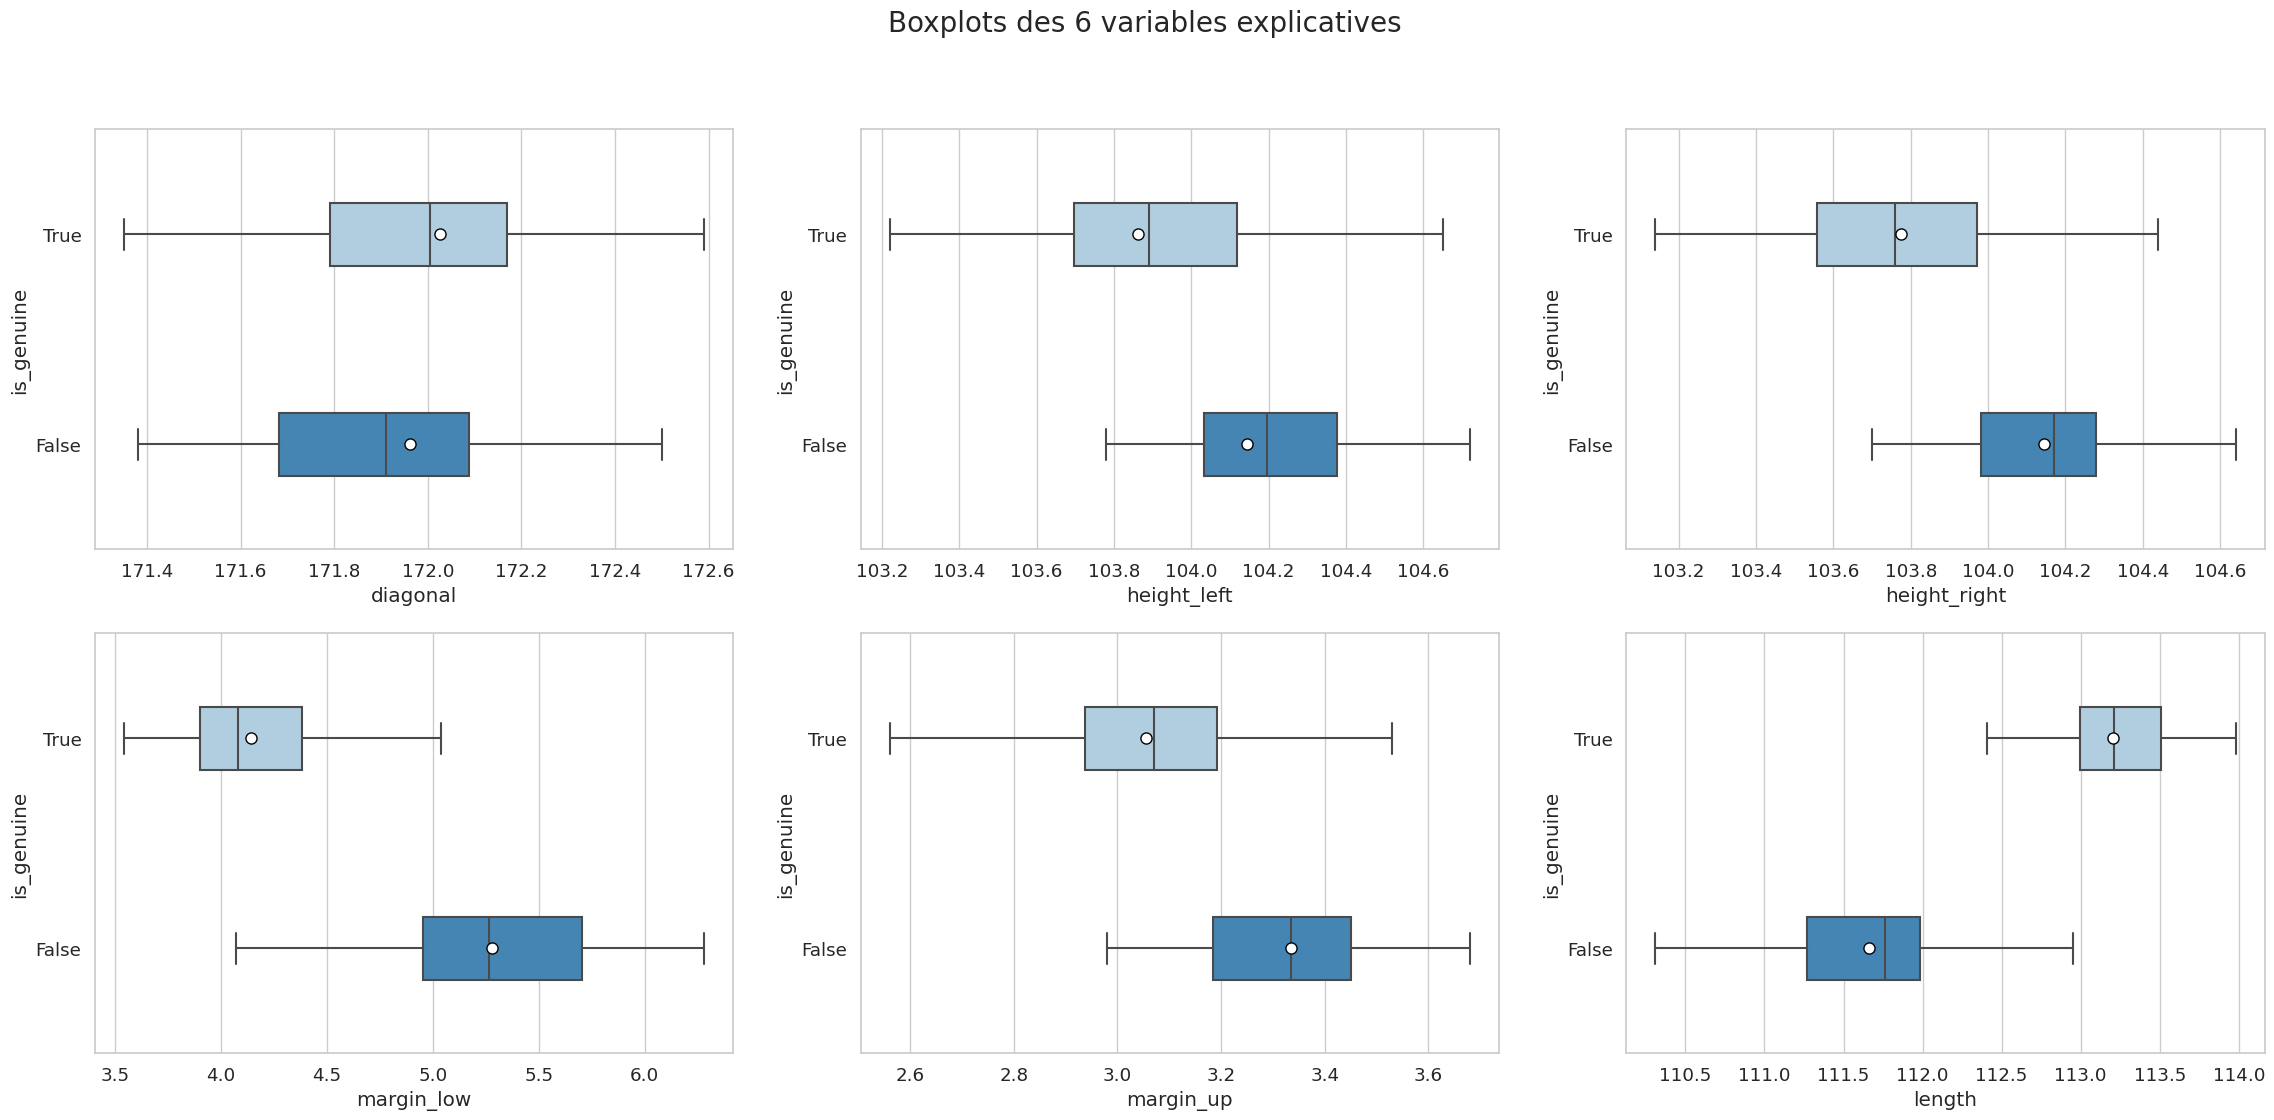

In [14]:
sns.set(font_scale=1.2, style='whitegrid')

fig, axes = plt.subplots(2, 3, figsize=(28, 12))
fig.suptitle('Boxplots des 6 variables explicatives', fontsize=20)

xx = [0,0,0,1,1,1]
yy = [0,1,2,0,1,2]

for a, b in enumerate(df.columns[1:]):
    
    ax = axes[xx[a], yy[a]]
    sns.boxplot(ax=ax, orient='h', x=b, y='is_genuine', data=df, width=.3, palette='Blues', showmeans=True, showfliers=False, saturation=0.8,
                meanprops={'marker':'o', 'markerfacecolor':'white', 'markeredgecolor':'black', 'markersize':'8'})

#plt.savefig('Boxplots des 6 variables explicatives.png', transparent=True)
plt.show();

### Anova

In [15]:
anova = df.loc[:, ['length', 'margin_low', 'is_genuine']]
anova['is_genuine'] = anova['is_genuine'].astype('object')
anova

,length,margin_low,is_genuine
0,112.83,4.52,True
1,113.29,4.01,True
2,113.84,4.40,True
3,113.63,3.73,True
4,113.55,5.04,True
...,...,...,...
165,111.78,5.24,False
166,110.91,5.04,False
167,110.68,4.88,False
168,111.87,4.73,False


In [16]:
anova_length = smf.ols('length~is_genuine', data=anova).fit()

In [17]:
# R-squared (coefficient of determination), it is the proportion of the variance in the dependent variable that is explained

print(f'R2 : {np.round(anova_length.rsquared, 4)}')

R2 : 0.6819


In [18]:
print('Tableau d\'analyse de la variance')
sm.stats.anova_lm(anova_length, typ=2)

Tableau d'analyse de la variance


,sum_sq,df,F,PR(>F)
is_genuine,98.478391,1.0,360.054076,1.234823e-43
Residual,45.949680,168.0,NaN,NaN


- La p-valeur de ce test est très petite et largement inférieure à 5 %.
- La longueur du billet a donc bien une influence significative sur sa qualité (vrai/faux), comme nous en avions eu l'intuition en regardant les boîtes à moustaches.

In [19]:
anova_margin_low = smf.ols('margin_low~is_genuine', data=anova).fit()

In [20]:
# R-squared (coefficient of determination), it is the proportion of the variance in the dependent variable that is explained

print(f'R2 : {np.round(anova_margin_low.rsquared, 4)}')

R2 : 0.6402


In [21]:
print('Tableau d\'analyse de la variance')
sm.stats.anova_lm(anova_margin_low, typ=2)

Tableau d'analyse de la variance


,sum_sq,df,F,PR(>F)
is_genuine,53.332036,1.0,298.896502,3.940145e-39
Residual,29.976202,168.0,NaN,NaN


- La p-valeur de ce test est très petite et largement inférieure à 5 %.
- La marge basse du billet a donc bien une influence significative sur sa qualité (vrai/faux), comme nous en avions eu l'intuition en regardant les boîtes à moustaches.

<img src='anova1.png' width=500px>
<img src='anova2.png' width=500px>

### Corrélations

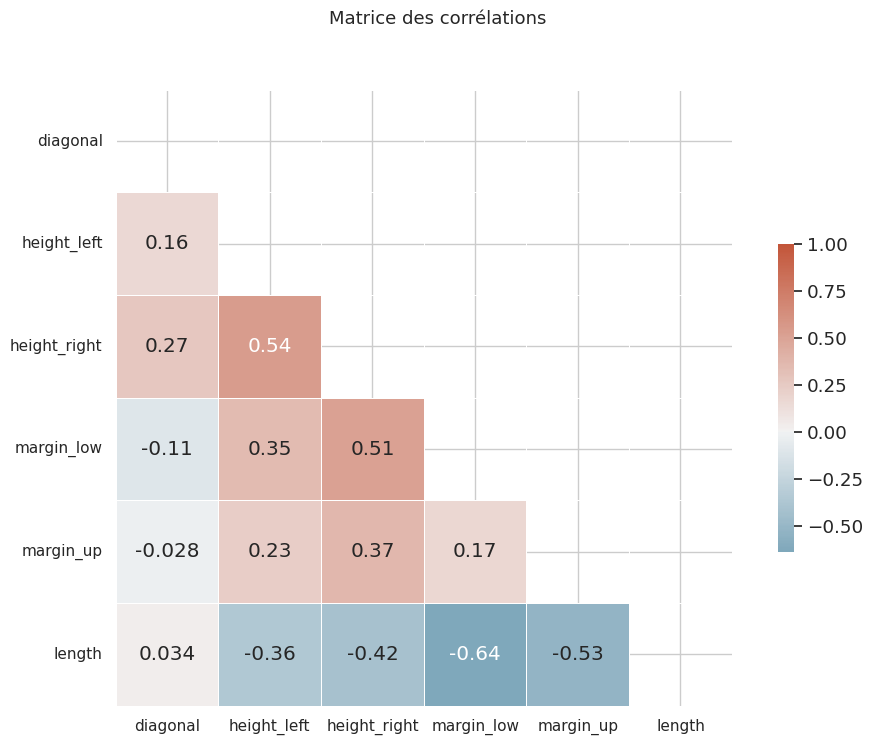

In [22]:
# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(12, 8))
f.suptitle('Matrice des corrélations', fontsize=13)

# Compute the correlation matrix
corr = df.corr(numeric_only=True)

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
g = sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, center=0, square=True, linewidths=.5, cbar_kws={'shrink': .5}, annot=True)
g.tick_params(axis='x', labelsize=11, labelrotation=0)
g.tick_params(axis='y', labelsize=11, labelrotation=0)

#plt.savefig('Matrice des corrélations.png', transparent=True)
plt.show();

Tableau de contingence + heatmap

In [23]:
# corr = np.corrcoef(df[col_names], rowvar=False) 
# w, v = np.linalg.eig(corr)
# print(*w, sep=', ')

/home/ec2-user/.miniforge3/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


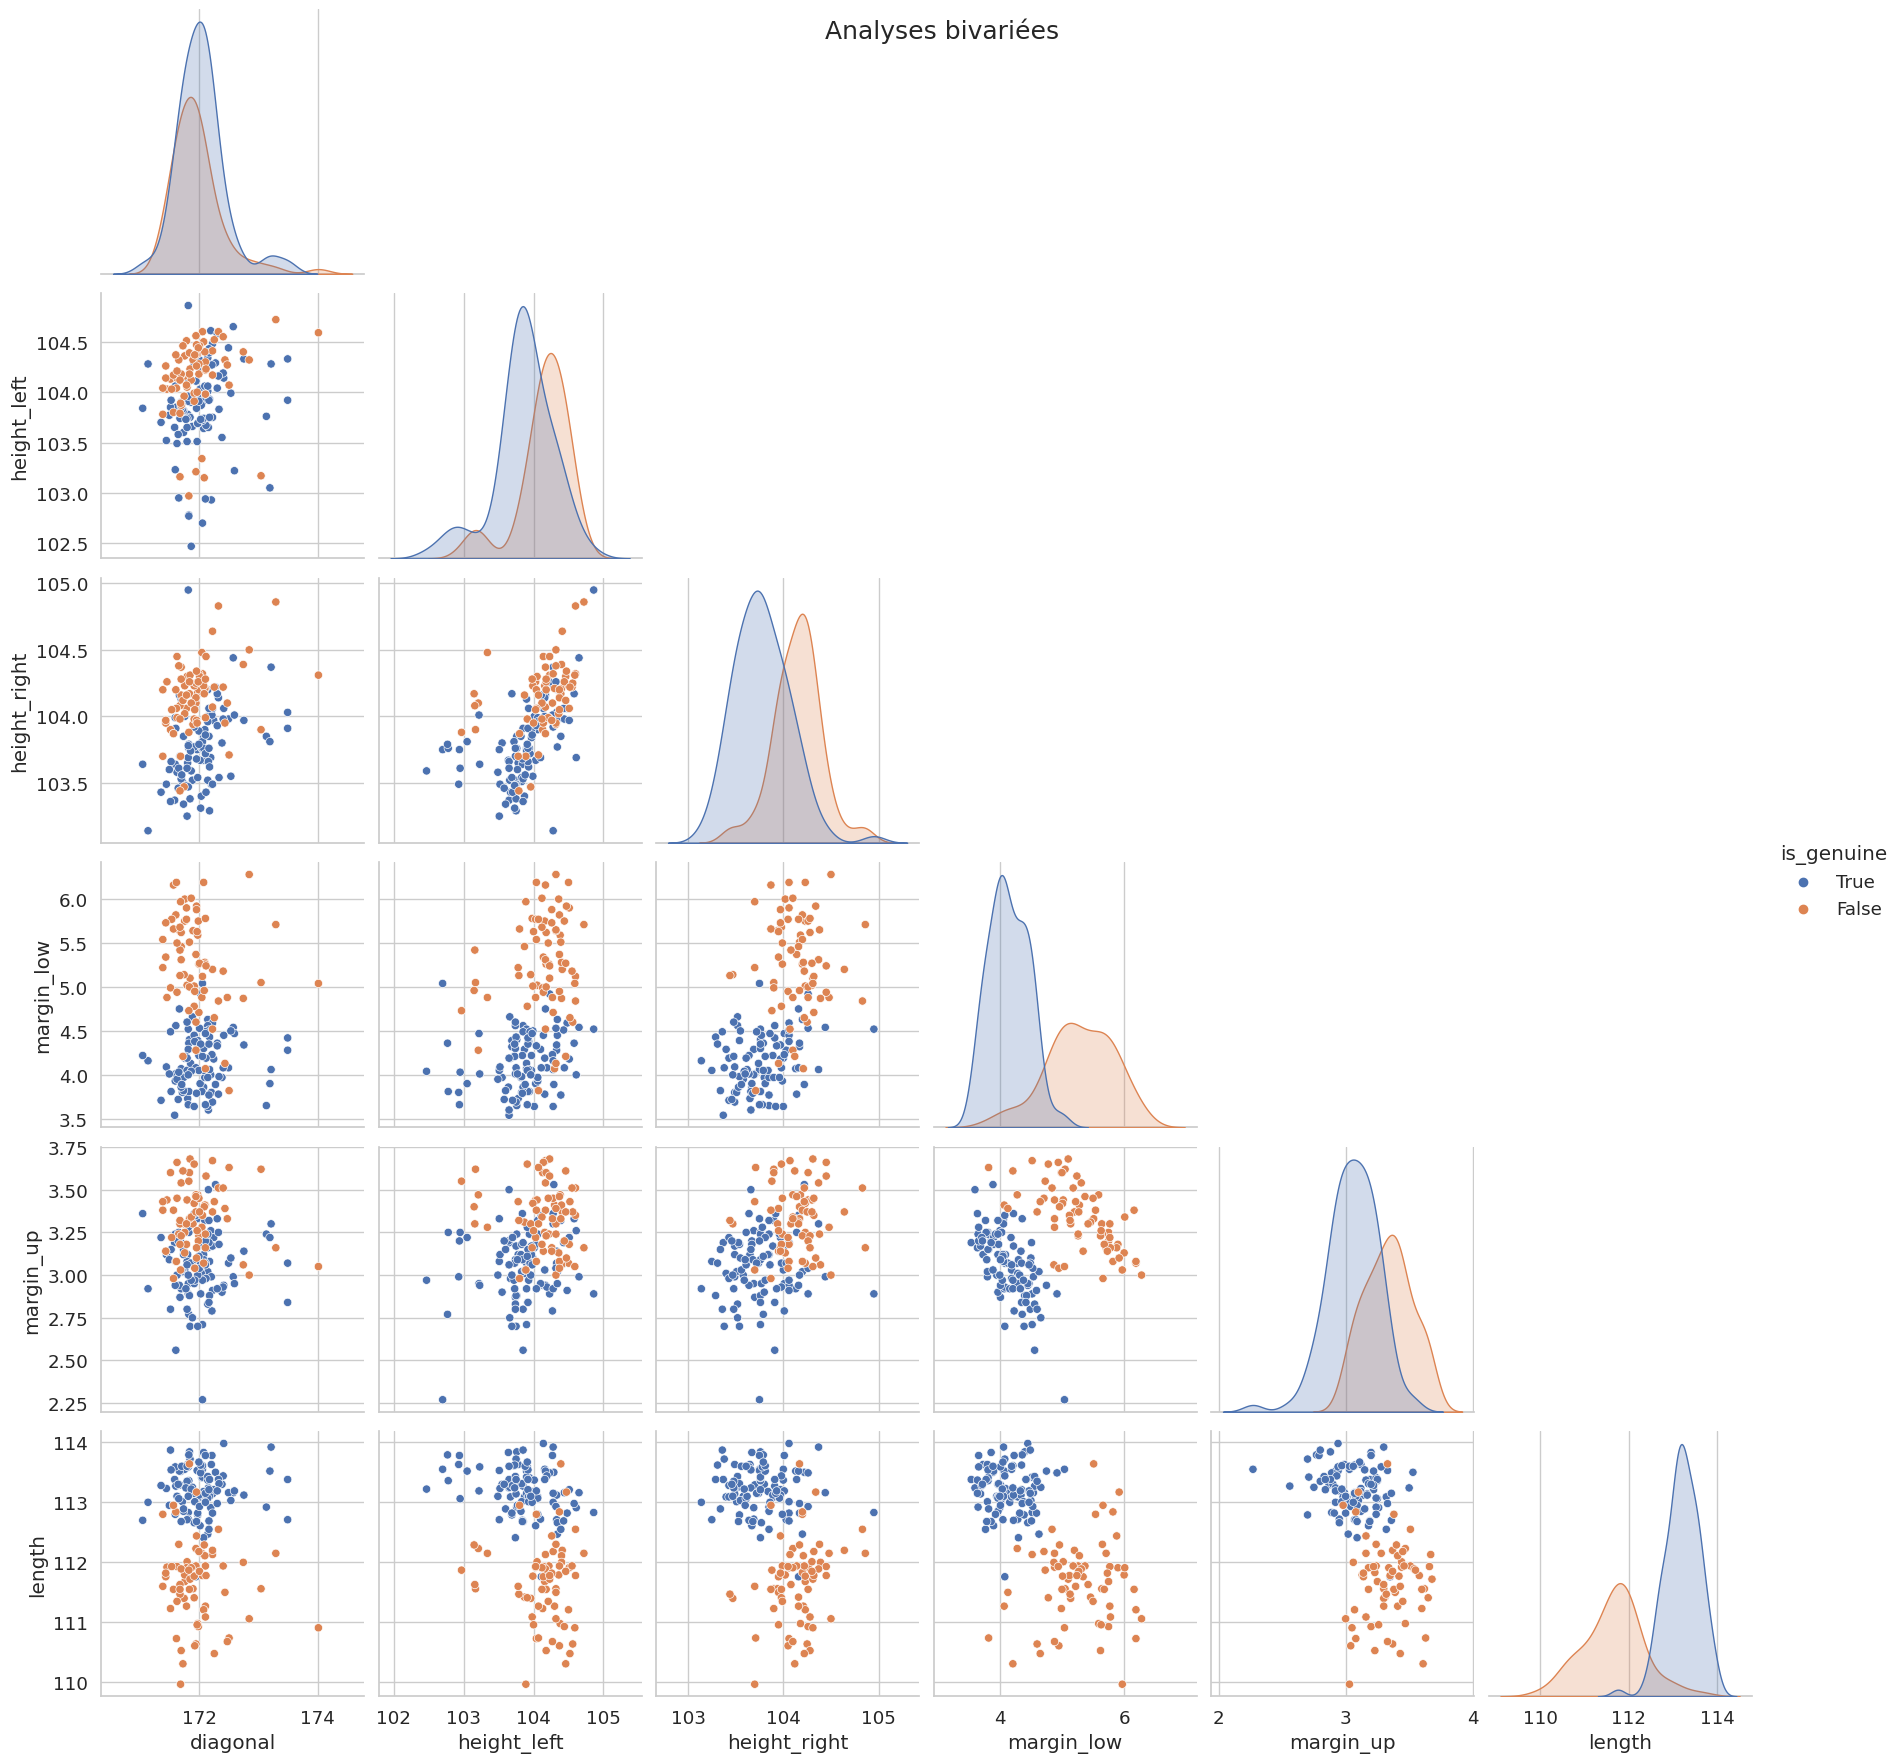

In [24]:
sns.pairplot(data=df, hue='is_genuine', hue_order=('True', 'False'), diag_kind='kde', corner=True, height=3)
plt.suptitle('Analyses bivariées', fontsize=18)
plt.show()

In [25]:
# Compute VIF data for each independent variable

vif = pd.DataFrame()
df_selected = df.drop(columns='is_genuine')
vif['features'] = df_selected.columns
vif['vif_factor'] = [variance_inflation_factor(df_selected.values, i) for i in range(df_selected.shape[1])]
vif.sort_values(by='vif_factor', ascending=False)

,features,vif_factor
2,height_right,193779.835994
0,diagonal,137979.486999
1,height_left,81832.552782
5,length,30297.492833
4,margin_up,301.702389
3,margin_low,104.082735


### Features importance

In [26]:
# features
X = df.drop(columns='is_genuine')

# target output
y = df['is_genuine']

In [27]:
# Top k features for classification

estimator = f_classif
selector = SelectKBest(estimator, k=6)
selector = selector.fit(X, y)
d = {'Features': X.columns, 'Keep': selector.get_support(), 'Scores': selector.scores_}
features = pd.DataFrame(data = d).sort_values(by='Scores', ascending=False).reset_index(drop=True)
features

,Features,Keep,Scores
0,length,True,360.054076
1,margin_low,True,298.896502
2,margin_up,True,86.413125
3,height_right,True,73.359040
4,height_left,True,19.980209
5,diagonal,True,0.934788


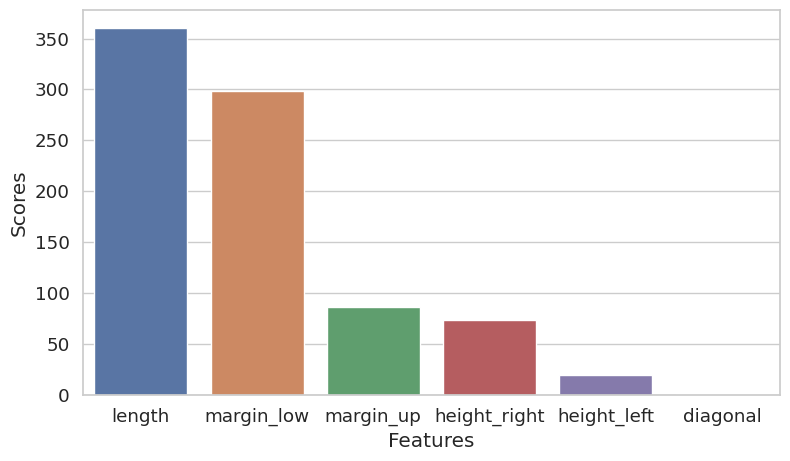

In [28]:
fig, ax = plt.subplots(figsize=(9, 5))
sns.barplot(x='Features', y='Scores', data=features, ax=ax)
plt.show()

### Droping features height_left and diagonal

In [29]:
df = df.drop(columns=['height_left', 'diagonal'])

### Scaling

Centering and scaling happen independently on each feature by computing the relevant statistics on the samples in the training set. Mean and standard deviation are then stored to be used on later data using transform.

Standardization of a dataset is a common requirement for many machine learning estimators : they might behave badly if the individual features do not more or less look like standard normally distributed data (e.g. Gaussian with 0 mean and unit variance).

For instance many elements used in the objective function of a learning algorithm (such as the RBF kernel of Support Vector Machines or the L1 and L2 regularizers of linear models) assume that all features are centered around 0 and have variance in the same order. If a feature has a variance that is orders of magnitude larger than others, it might dominate the objective function and make the estimator unable to learn from other features correctly as expected.

In [30]:
X = df.drop(columns='is_genuine').to_numpy()
X[:3]

array([[104.95,   4.52,   2.89, 112.83],
       [103.7 ,   4.01,   2.87, 113.29],
       [103.76,   4.4 ,   2.88, 113.84]])

In [31]:
# Centrage et réduction des données
std_scale = preprocessing.StandardScaler().fit(X)

# Save the model
dump(std_scale, '_std_scale.joblib')

X_scaled = std_scale.transform(X)
X_scaled[:3]

array([[ 3.09656321, -0.13159013, -1.18987367,  0.28163308],
       [-0.69125444, -0.86012554, -1.27473985,  0.78069736],
       [-0.50943919, -0.30301023, -1.23230676,  1.37740465]])

In [32]:
df_scaled = pd.DataFrame(X_scaled, index = df.index, columns = df.drop(columns='is_genuine').columns)
df_scaled.insert(0, 'is_genuine', df['is_genuine'])
df_scaled[:3]

,is_genuine,height_right,margin_low,margin_up,length
0,True,3.096563,-0.131590,-1.189874,0.281633
1,True,-0.691254,-0.860126,-1.274740,0.780697
2,True,-0.509439,-0.303010,-1.232307,1.377405


In [33]:
df[:3]

,is_genuine,height_right,margin_low,margin_up,length
0,True,104.95,4.52,2.89,112.83
1,True,103.70,4.01,2.87,113.29
2,True,103.76,4.40,2.88,113.84


## PCA

In [34]:
# ACP

pca = decomposition.PCA()
X_projected = pca.fit_transform(X_scaled)
n_comp = pca.n_components_
len(df.columns)-1

4

In [35]:
X_projected[:3]

array([[-0.78484421,  1.3798023 ,  2.69369864, -1.15121198],
       [ 1.75936851,  0.46402272,  0.00633102, -0.37598398],
       [ 1.70445139,  0.80871662,  0.33304129,  0.31156604]])

In [36]:
# Append the principle components for each entry to the dataframe

df_projected = df.copy()

for i in range(0, n_comp):
    df_projected['F' + str(i + 1)] = X_projected[:, i]

df_projected[:5]

,is_genuine,height_right,margin_low,margin_up,length,F1,F2,F3,F4
0,True,104.95,4.52,2.89,112.83,-0.784844,1.379802,2.693699,-1.151212
1,True,103.70,4.01,2.87,113.29,1.759369,0.464023,0.006331,-0.375984
2,True,103.76,4.40,2.88,113.84,1.704451,0.808717,0.333041,0.311566
3,True,103.65,3.73,3.12,113.63,1.797554,-0.621256,0.193664,0.103579
4,True,103.75,5.04,2.27,113.55,2.169392,3.389582,-0.136134,-0.422254


In [37]:
scree = pca.explained_variance_ratio_*100

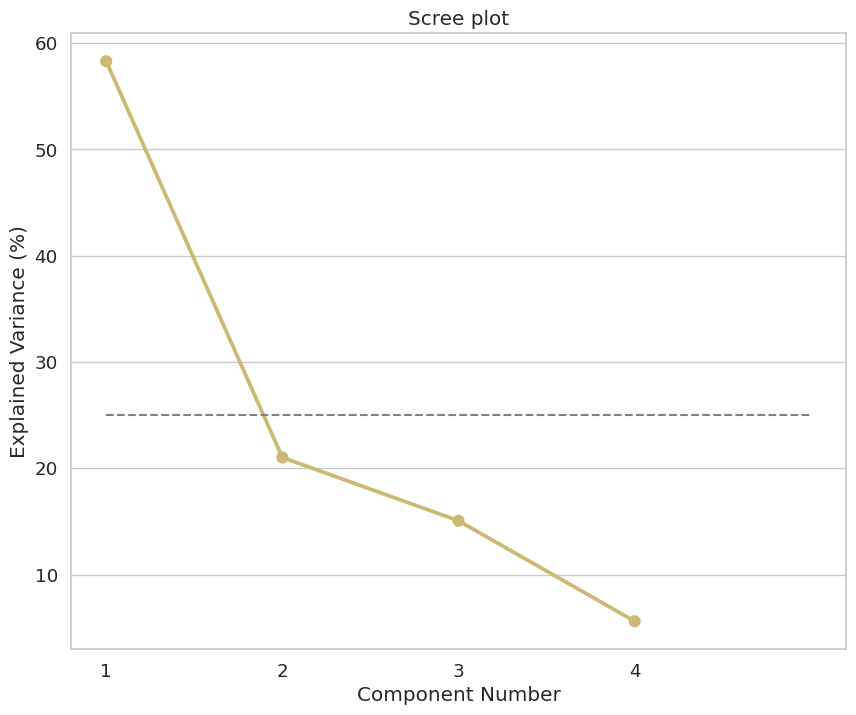

In [38]:
# Do a scree plot

fig, ax = plt.subplots(figsize=(10, 8))
ind = np.arange(0, n_comp)+1

sns.pointplot(x=ind, y=scree, color='y')

ax.plot([0, n_comp], [np.round(100/n_comp, 2), np.round(100/n_comp, 2)], color='grey', ls='--')

ax.set_title('Scree plot')
ax.set_xlabel('Component Number')
ax.set_ylabel('Explained Variance (%)')
plt.show()

In [39]:
pca.components_

array([[-0.48929073, -0.51188492, -0.42338198,  0.56508061],
       [ 0.15656032,  0.5725426 , -0.80307315,  0.05251063],
       [ 0.82253043, -0.23699209,  0.02515694,  0.51637736],
       [-0.24398184,  0.59498198,  0.41855507,  0.6413119 ]])

In [40]:
pc1 = pca.components_[0]

my_dict = {key:value for (key, value) in zip(df.columns[1:], pc1)}

print('F1')
print(my_dict)

F1
{'height_right': -0.48929073164976805, 'margin_low': -0.5118849240011891, 'margin_up': -0.42338198307177843, 'length': 0.5650806145251662}


In [41]:
pc2 = pca.components_[1]

my_dict = {key:value for (key, value) in zip(df.columns[1:], pc2)}

print('F2')
print(my_dict)

F2
{'height_right': 0.15656032266020034, 'margin_low': 0.5725425951138734, 'margin_up': -0.8030731450417419, 'length': 0.05251062617767023}


In [42]:
# Coordonnées des composantes
composantes=pd.DataFrame(pca.components_)

In [43]:
composantes.columns=df.columns[1:]
composantes.index=[f'CP{x}' for x in range(1, n_comp+1)]
composantes

,height_right,margin_low,margin_up,length
CP1,-0.489291,-0.511885,-0.423382,0.565081
CP2,0.156560,0.572543,-0.803073,0.052511
CP3,0.822530,-0.236992,0.025157,0.516377
CP4,-0.243982,0.594982,0.418555,0.641312


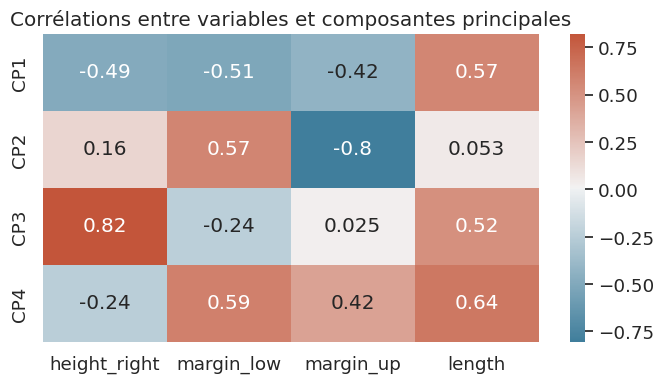

In [44]:
# Corrélations entre les variables et les composantes principales (influence de chaque variable sur chaque axe factoriel)

fig, ax = plt.subplots(figsize=(8, 4))
sns.heatmap(composantes, annot=True, cmap=cmap)
plt.title('Corrélations entre variables et composantes principales')
plt.show()

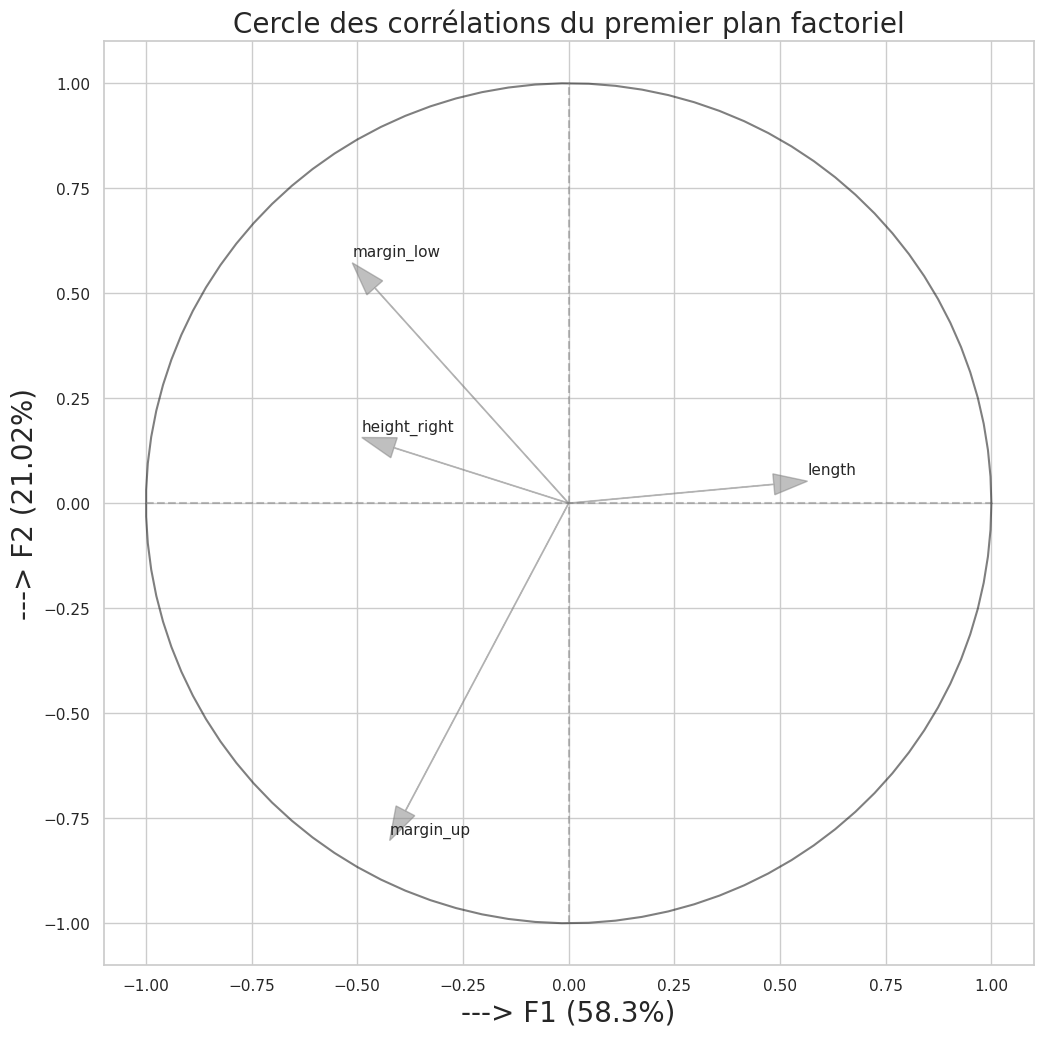

In [45]:
sns.set_theme(style='whitegrid')
fig, ax = plt.subplots(figsize=(12, 12))

# Plot a variable factor map for the first two dimensions.
f1, f2 = (1, 2)

for i in range(0, pca.components_.shape[1]):
    ax.arrow(0, 0,  # Start the arrow at the origin
             pca.components_[(f1-1), i],  #0 for F1
             pca.components_[(f2-1), i],  #1 for F2
             head_width=0.05, head_length=0.08, alpha=0.5, length_includes_head=True, color='grey')

    ax.text(pca.components_[(f1-1), i],
            pca.components_[(f2-1), i]+.015,
            df_projected.columns.values[i+1], size=11)

# Add a unit circle for scale
an = np.linspace(0, 2 * np.pi, 100)
ax.plot(np.cos(an), np.sin(an), color='black', alpha=.5)  

# affichage des lignes horizontales et verticales
plt.plot([-1, 1], [0, 0], color='grey', ls='--', alpha=0.5)
plt.plot([0, 0], [-1, 1], color='grey', ls='--', alpha=0.5)


# nom des axes, avec le pourcentage d'inertie expliqué
plt.xlabel(f'---> F{f1} ({np.round(scree[(f1-1)], 2)}%)', fontsize=20)
plt.ylabel(f'---> F{f2} ({np.round(scree[(f2-1)], 2)}%)', fontsize=20)

ax.set_title('Cercle des corrélations du premier plan factoriel', fontsize=20)

plt.savefig('Cercle des corrélations.png', transparent=True);

plt.show()

/home/ec2-user/.miniforge3/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
/home/ec2-user/.miniforge3/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
/home/ec2-user/.miniforge3/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
/home/ec2-user/.miniforge3/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


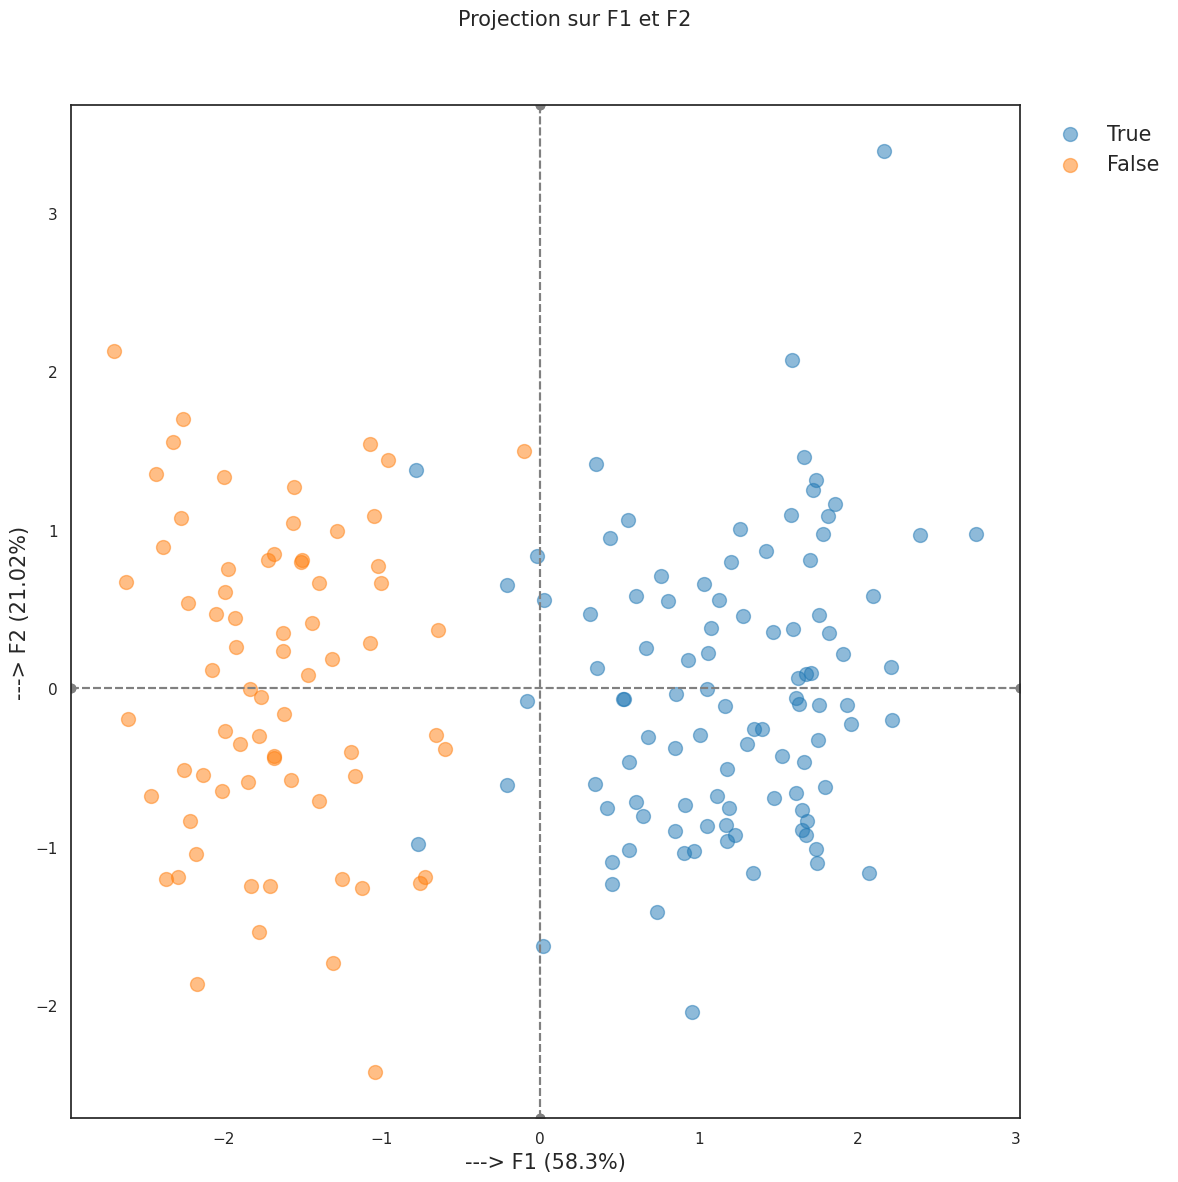

In [46]:
sns.set_theme(style='white')

palette = {'True': 'tab:blue',
           'False': 'tab:orange'}

# Show the points in terms of the first two dimensions
f1, f2 = (1, 2)

g = sns.lmplot(x=f'F{f1}',
               y=f'F{f2}',
               hue='is_genuine',
               data=df_projected,
               fit_reg=False,
               scatter=True,
               height=12,
               palette=palette,
               facet_kws=dict(despine=False),
               scatter_kws={'s':100, 'alpha':.5})


g.refline(y=0, x=0)
g.set_axis_labels(f'---> F{f1} ({np.round(scree[(f1-1)], 2)}%)', f'---> F{f2} ({np.round(scree[(f2-1)], 2)}%)', fontsize=15)

sns.move_legend(g, 'upper left', bbox_to_anchor=(.85, .90), fontsize=15, title=None)

g.fig.subplots_adjust(top=.9)
g.fig.suptitle('Projection sur F1 et F2', fontsize=15)

#g.set(xlim=(-3, 3), ylim=(-3, 3))
plt.axis('image')

plt.savefig('Projection sur F1 et F2.png', transparent=True)
plt.show();

### L'axe F1 sépare bien les 2 catégories de billets, qui correspondent aux faux et vrais billets.
### Après réduction de dimension, on peut utiliser des algorithmes de clustering pour prédire la qualité des billets.

In [47]:
# PCA

n_comp = 2
pca_new = decomposition.PCA(n_components=n_comp)
pca_new.fit(X_scaled)

# Save the model
dump(pca_new, '_pca.joblib')

x_new = pca_new.transform(X_scaled)

In [48]:
y = df['is_genuine'].apply(lambda x:1 if (x == 'True') else 0)

In [49]:
X_train, X_test, y_train, y_test = train_test_split(x_new, y, test_size = 0.25, stratify=y, random_state=1)

In [50]:
print('train\n', y_train.value_counts()/len(y_train), sep='')
print('\n')
print('test\n', y_test.value_counts()/len(y_test), sep='')

train
is_genuine
1    0.590551
0    0.409449
Name: count, dtype: float64


test
is_genuine
1    0.581395
0    0.418605
Name: count, dtype: float64


## Prédictions par clustering hiérarchique

In [51]:
# Initialization
agglo = AgglomerativeClustering(2)

##### Entraînement et calcul des performances du modèle

In [52]:
# Prediction on train set
pred = agglo.fit_predict(X_train)

In [53]:
# Silhouette score for the training set
print(silhouette_score(X_train, pred))

0.5612923733296695


***
***

#### Le clustering hiérarchique ne peux pas s'appliquer sur de nouvelles données sans ré-entraînement.
#### Pour la suite, je vais utiliser le clustering kmeans qui n'a pas ce problème : une fois entraîné (ce qui permet de déterminer les centroïdes), il peut être appliqué sur de nouvelles données.

***
***

## Prédictions par KMeans

In [54]:
# Initialization
km = KMeans(n_clusters=2, n_init=10, random_state=1)

# Training
km.fit(X_train)

# Save the model
dump(km, '_kmeans.joblib');

### Calcul de performance du modèle

In [55]:
# Prediction on train set
y_pred_train = km.predict(X_train)

# Prediction on test set
y_pred_test = km.predict(X_test)

In [56]:
# Silhouette score for the training set
print(silhouette_score(X_train, y_pred_train))

# # Silhouette score for the test set
# print(silhouette_score(X_test, y_pred_test))

0.5629680425196022


In [57]:
y_pred_test

array([1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1,
       1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1],
      dtype=int32)

In [58]:
np.array(y_test)

array([0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0,
       0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0])

In [59]:
pd.Series.mode(pd.Series(y_pred_test == np.array(y_test)))[0]

False

In [60]:
# Le modèle a appris 2 clusters, étiquettés '0' et '1'.
# Testons si l'étiquette '1' correspond aux vrais billets.

pd.Series.mode(pd.Series(y_pred_test == np.array(y_test)))[0]

False

In [61]:
# Je fais correspondre l'étiquettte '1' avec le cluster appris qui correspond au vrais billets.

y_pred_test = y_pred_test ^ 1

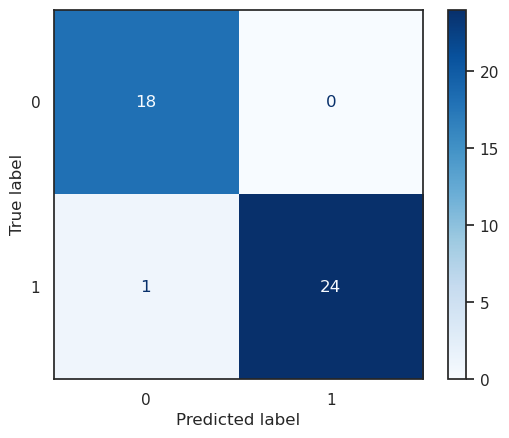

In [62]:
# Confusion matrix
# IMPORTANT: first argument is true values, second argument is predicted values
# this produces a 2x2 numpy array (matrix)

tn, fp, fn, tp = confusion_matrix(y_test, y_pred_test).ravel()
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_test, cmap='Blues');

<img src='confusion.png' width=350px>

In [63]:
print(f'Nombre d\'erreurs du KMeans : {fp + fn}')

Nombre d'erreurs du KMeans : 1


In [64]:
# Accuracy : overall, how often is the classifier correct ?
# (tp + tn) / float(tp + tn + fp + fn)

accuracy = accuracy_score(y_test, y_pred_test)
print(f'Accuracy: {np.round(accuracy, 2)}')

Accuracy: 0.98


In [65]:
# Recall : when the actual value is positive, how often is the prediction correct ?
# tp / float(fn + tp)

recall = recall_score(y_test, y_pred_test)
print(f'Recall: {recall}')

Recall: 0.96


In [66]:
# precision : when a positive value is predicted, how often is the prediction correct ?
# tp / float(tp + fp)

precision = precision_score(y_test, y_pred_test)
print(f'Precision: {precision}')

Precision: 1.0


In [67]:
df_compare = pd.DataFrame(index=['kmeans'], columns=['Accuracy (%)', 'Precision (%)', 'Recall (%)'])

In [68]:
df_compare.loc['kmeans', 'Accuracy (%)'] = np.round(accuracy*100, 2)
df_compare.loc['kmeans', 'Precision (%)'] = np.round(precision*100, 2)
df_compare.loc['kmeans', 'Recall (%)'] = np.round(precision*100, 2)

In [69]:
df_compare

,Accuracy (%),Precision (%),Recall (%)
kmeans,97.67,100.0,100.0


## Prédictions sur de nouvelles données

In [70]:
# Chargement des modèles
std_scale = load('_std_scale.joblib')
pca = load('_pca.joblib')
km = load('_kmeans.joblib') 

# Import du fichier test
df_raw = pd.read_csv('test.csv', encoding='utf_8', encoding_errors='strict')

# Centrage et réduction des données
X_scaled = std_scale.transform(df_raw.drop(columns=['diagonal', 'height_left', 'id']).to_numpy())

# PCA
x = pca.transform(X_scaled)

# RandomForestClassifier
y_pred = km.predict(x)

# Je fais correspondre l'étiquettte '1' avec le cluster appris qui correspond au vrais billets.
y_pred = y_pred ^ 1

# Reconstruction du dataframe
df_test = pd.DataFrame(x)
df_test['ID'] = df_raw['id']
df_test = df_test.set_index('ID')

# Affichage des prédictions
df_test['prédiction'] = y_pred
df_test['prédiction'] = df_test['prédiction'].apply(lambda x:'VRAI' if (x == 1) else 'FAUX')

df_test.iloc[:, -1:]

,prédiction
ID,
billet_1,VRAI
billet_2,FAUX
billet_3,VRAI
billet_4,FAUX
billet_5,FAUX
